<h3>Training and Testing a Classification Model</h3>

In this notebook, I will build a training/test/validation set of sentences from Medium articles. I will label the set and extract features. Then I will train a model and cross-validate.

In [1]:
# import required libraries

import math
import pandas as pd
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from random import randint
from sklearn import linear_model, metrics
from gensim import corpora, models, similarities
from collections import defaultdict
import pickle

<b>Step One:</b> Separate out training from test sets.

In [2]:
# connect to postgresql db
username = 'kimberly'
dbname = 'medium'

dbe = create_engine('postgres://%s@localhost/%s'%(username,dbname))


In [3]:
# get df, drop missing data
df = pd.read_sql('articles', dbe, index_col='postid')
df = df.dropna(axis=0,how='any')


<b>Functions to format row of the df, as well as do text processing</b>

In [4]:
# functions to convert nlikes and ncomments to integer
def convert_K(nstr):
    spl = nstr.split('K')
    if len(spl)==1:
        return int(float(spl[0]))
    else:
        return int(float(spl[0])*1000)
    
def convert_str(nstr):
    nstr = nstr.replace(',','')
    if nstr=='':
        return None
    else:
        return int(nstr)

In [5]:
def process_paragraph(par,swords):
    '''takes one paragraph (string); performs lower, tokenize, remove punctuation/stop words'''
    par = par.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(par)
    nstop_tokens = [t for t in tokens if (t not in swords and t not in string.punctuation)]
    return nstop_tokens                      

def process_text_paragraphs(atext,origdb,swords):
    '''atext is a list or series of textstrings (one from each article), 
    origdb is a list or series of corresponding original databse IDs (ints from 0-4)'''
    # initial text split
    alist = [initial_text_split(a,int(o)) for a,o in zip(atext,origdb)]
        
    # remove very long articles
    removed_articles = [aix for aix,a in enumerate(alist) if len(a)>=250]
    alist = [a for a in alist if len(a)<250]
    
    # process each paragraph
    alist = [[process_paragraph(p,swords) for p in a] for a in alist]
    
    return [alist,removed_articles]

def process_text_sentences(atext,origdb,swords):
    '''same processing, but does a sentence breakup rather than paragraph'''
    # initial text split
    alist = [initial_text_split(a,int(o)) for a,o in zip(atext,origdb)]
    
    # remove very long articles
    removed_articles = [aix for aix,a in enumerate(alist) if len(a)>=250]
    alist = [a for a in alist if len(a)<250]
    
    # change paragraph splits to sentence splits
    alist = [plist_to_slist(plist) for plist in alist]
    
    # process each paragraph
    alist = [[process_paragraph(p,swords) for p in a] for a in alist]
    
    return [alist,removed_articles]

def initial_text_split(article_text,origdb):
    '''takes article text and original db and performs appropriate splitting'''
    if origdb in [1,2,3]:
        # split into paragraphs
        plist = article_text.split('/n')

        # remove \n symbols from within words
        plist = [p.replace('\n','') for p in plist]
    
    else:
        # split into paragraphs
        plist = article_text.split('\n')
        
    return plist

def plist_to_slist(plist):
    '''changes a list of paragraphs to a list of sentences'''
    spl = [re.split('[/./!/?]',par) for par in plist]
    return [s for p in spl for s in p if len(s)>1]


<b>Now we will use these functions to format the text</b>

In [15]:
# define stop word corpus and process text
swords = stopwords.words('english')
processing_output = process_text_sentences(df.text,df.origdb,swords)
ptext = processing_output[0]


In [16]:
# drop too-long articles
removed_articles = processing_output[1]
dfDrop = df.drop(df.index[removed_articles])
#for rem in removed_articles:
#    del ptext[rem]


In [17]:
# process highlights and titles
htext = [plist_to_slist([hilite]) for hilite in dfDrop.highlight]
htext = [[process_paragraph(hsent,swords) for hsent in art] for art in htext]
ttext = [plist_to_slist([title]) for title in dfDrop.title]
ttext = [[process_paragraph(tsent,swords) for tsent in art] for art in ttext]


In [20]:
len(htext)

4640

<b>Now, we will LABEL each sentence as 1 or 0 (in highlight or not)</b>

In [21]:
# LABEL whether each sentence is in the highlight
plabel = []
for a,art in enumerate(ptext):
    alabel = []
    for s in art:
        alabel.append(any([(s==hs) for hs in htext[a]]))
    plabel.append(alabel)


In [22]:
# find articles with no highlight in ptext
len(plabel)
h_in_ptext = [any(a) for a in plabel]
print(len(plabel) - sum(h_in_ptext))
print(sum(h_in_ptext))
len(plabel)

1457
3183


4640

Note that several (about 1/4) of the articles with a highlight do NOT contain the highlight in the p-text (i.e., in the text scraped from p tags in the html).
<br><br>
These can still be used as negative examples. We will check to see if there is a corresponding positive example, and if not, use the highlight itself.

Finally, we get the dataframe together...

In [23]:
# format rows in dataframe
dfDrop.nlikes = dfDrop.nlikes.map(convert_K)
dfDrop.ncomments = dfDrop.ncomments.map(convert_str)


In [460]:
#print(len(dfDrop.iloc[637].text))
#postidToIgnore = dfDrop.index[637]

51


In [24]:
# add processed text to df
dfDrop.text = ptext
dfDrop.highlight = htext
dfDrop.title = ttext
dfDrop['label'] = plabel


In [25]:
# add article wcount to df
wcount = [sum([len(par) for par in art]) for art in ptext]
dfDrop['wcount'] = wcount

Training data will include (about) 80% of the articles in the dataframe. 
First, we separate out a random set of these.

In [221]:
# choose test/train sets
#test_ix = randint(0,999)
#dfTest = dfDrop.iloc([test_ix])
#dfTrain = dfDrop.drop(dfDrop.index[test_ix])

<b>Set up training data</b>

In [27]:
print(dfDrop.shape)
dfDrop.head()

(4640, 15)


,title,popdate,url,userid,username,highlight,nlikes,ncomments,ntags,origdb,tags,text,npar,label,wcount
postid,,,,,,,,,,,,,,,
1015a0f4961d,"[[day, one, president, obama, first, family, l...",2016-03-21,https://medium.com/@ObamaWhiteHouse/day-one-pr...,ca9f8f16893b,The Obama White House,"[[today, air, force, one, touched, havana, fir...",336,15.0,3.0,3.0,"Cuba,Twitter,Cuba Trip","[[hola, desde, cuba], [today, air, force, one,...",20.0,"[False, True, False, False, False, False, Fals...",522
101a407e8c61,"[[make, makes]]",2016-06-02,https://medium.com/the-mission/you-dont-make-i...,5ce28105ffbc,Jon Westenberg,"[[make, makes]]",549,37.0,3.0,3.0,"Entrepreneurship,Startup,Life","[[always, wanted, make], [grew, dreaming, rock...",21.0,"[False, False, False, False, False, False, Fal...",393
1030d29376f1,"[[ux, infinite, scrolling, vs], [pagination]]",2016-05-02,https://uxplanet.org/ux-infinite-scrolling-vs-...,bcab753a4d4e,Nick Babich,"[[instances, infinite, scrolling, effective], ...",1910,46.0,4.0,3.0,"UX,Design,User Experience,UX Design","[[use, infinite, scrolling, pagination, conten...",34.0,"[False, False, False, False, False, False, Fal...",850
10315016b299,"[[lesson, stereotypes]]",2016-08-20,https://medium.com/@mramsburg85/a-lesson-on-st...,d38709ba4e06,Michael Ramsburg,"[[stereotypes, strip, culture, like, mountains...",583,103.0,5.0,3.0,"Stereotypes,Appalachia,Culture,Essay,Opinion","[[stereotypes], [mrs], [mitchell, sixth, grade...",12.0,"[False, False, False, False, False, False, Fal...",381
10321e751c6d,"[[republican, never, trump, means]]",2016-07-30,https://medium.com/@ccmccain/for-this-republic...,4e965facd5f9,Caroline McCain,"[[trump, statement, view, unforgivable, speaks...",2500,302.0,5.0,3.0,"Hillary Clinton,Donald Trump,Never Trump,2016 ...","[[know, know, woman, fiercely, loyal, friends,...",45.0,"[False, False, False, False, False, False, Fal...",993


<b>Sentence-wise split:</b> We set up the data by sentence...

In [225]:
# set up a dataframe for sentences...
dfS = pd.DataFrame()

for art in dfDrop.index
    slist = dfDrop.text[art]
    for nsent in range(len(slist)):
        sent = slist[nsent]
        dfRow = pd.DataFrame([art,sent,len(sent),nsent,len(slist),dfDrop.label[art][nsent]])
        dfRow = dfRow.T
        dfRow.columns = ['postid','sentence','swcount','sposition','alength','slabel']
        dfS = pd.concat([dfS,dfRow])
    

In [227]:
print(dfS.shape)
dfS.head()

(434741, 6)


,postid,sentence,swcount,sposition,alength,slabel
0,1015a0f4961d,"[hola, desde, cuba]",3,0,52,False
0,1015a0f4961d,"[today, air, force, one, touched, havana, firs...",9,1,52,True
0,1015a0f4961d,"[question, remarkable, moment, relationship, u...",9,2,52,False
0,1015a0f4961d,"[also, landmark, progress, made, since, presid...",29,3,52,False
0,1015a0f4961d,"[trip, also, professionally, personally, meani...",19,4,52,False


In [228]:
dfS.to_sql('sentences',dbe)

In [317]:
# now, add sentence entries for the highlights not in ptext.

h_in_ptext = [any(a) for a in plabel]
dfNotInP = dfDrop.drop(dfDrop.index[h_in_ptext])
dfNotInP.shape


(1457, 15)

In [319]:
#dfComb = dfS.copy()

# for art in dfNotInP.index:
#     slist = dfNotInP.text[art]
#     for nsent in range(len(slist)):
#         sent = slist[nsent]
#         dfRow = pd.DataFrame([art,sent,len(sent),nsent,len(slist),dfNotInP.label[art][nsent]])
#         dfRow = dfRow.T
#         dfRow.columns = ['postid','sentence','swcount','sposition','alength','slabel']
#         dfComb = pd.concat([dfComb,dfRow])


In [320]:
dfComb.to_sql('sentences_train_addnotinp',dbe)

In [461]:
dfComb.shape

(564102, 6)

<b>Adding article data:</b> We perform a merge to add article-wise data...

In [462]:
# left merge dfS -> dfTrain on postid

dfX = pd.merge(dfS, dfTrain[['title','nlikes','npar','wcount']], 
               how='left', left_on='postid', left_index=False, right_index=True, sort=False)
print(dfX.shape)
nsamp = dfX.shape[0]
dfX.isnull().any()
#dfX.head()

(434741, 10)


postid       False
sentence     False
swcount      False
sposition    False
alength      False
slabel       False
title        False
nlikes       False
npar         False
wcount       False
dtype: bool

Note that the 'ncomments' column has a bunch of NaNs, so here we have dropped it. Later we will investigate why (is it the dumb `convert_str()` function?).

In [463]:
dfX = dfX.dropna(how='any')
dfX.shape[0]

434741

<b>Now, we set up the model itself.</b>

In [464]:
# scikitlearn logistic regression... fit (with 2/3 of X, y from above)

dfY = dfX['slabel']
dfX = dfX[['swcount','sposition','alength','nlikes','wcount']]

In [465]:
spl = math.floor(2*nsamp/3)
ytrain = dfY.iloc[0:spl].astype(int)
Xtrain = dfX.iloc[0:spl]
ytest = dfY.iloc[spl:].astype(int)
Xtest = dfX.iloc[spl:]
print(ytrain.shape)
print(Xtrain.shape)
lrm = linear_model.LogisticRegression()
lrm.fit(X,y)

(289827,)
(289827, 5)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [466]:
# test on the 2/3 of training set
print(lrm.score(Xtrain,ytrain), 1 - ytrain.mean())

# test on the other 1/3 of X, y
print(lrm.score(Xtest,ytest), 1 - ytest.mean())

0.98661270344 0.98661270344
0.985922685179 0.985922685179


The model is predicting "no highlight" for every sample. This is what I expected, given the extremely unbalanced nature of the data. I will try balancing techniques (just as soon as I get Flask to work...)
<br><br>
Okay. Flask works. Now I need a predicting model.
<br><br>
<ul>
<li>The very first thing to do is to add the other positive examples I am missing. Find the instances of highlights not included in the ptext adn add them to the dfS. <i><b>Done above, resulting in dfComb</b></i></li>
<li>THEN add the new dfS to the databse!!</li>
<li>The next thing, I think, is to try the tf-idf embedding via <b>gensim</b>. Cluster the words based on term frequency v. inverse article frequency, then choose clusters that correspond the the first few hundred eigenvectors of the basis.</li>
<li>Once you have done that, </li>

</ul>


In [ ]:
# make ROC curve to compare thresholds

<b>Adding New Features</b>

The first task is getting the text by article and making tf-idf vectors.
<ol>
<li>Text by article is created by joining sentences. </li>
<li>Frequency count of each word in the whole corpus. </li>
<li>Remove words that appear only once. </li>
<li>Create a dictionary and a corpus. </li>
<li></li>
</ol>

In [333]:
# text by article
def to_atext(art):
    ntext = []
    for s in art:
        ntext.extend(s)
    return ntext


In [334]:
# flatten second row
atext = [to_atext(art) for art in ptext]
print(atext[0])

['hola', 'desde', 'cuba', 'today', 'air', 'force', 'one', 'touched', 'havana', 'first', 'time', 'history', 'question', 'remarkable', 'moment', 'relationship', 'united', 'states', 'cuba', 'governments', 'people', 'also', 'landmark', 'progress', 'made', 'since', 'president', 'obama', 'decided', 'reform', 'failed', 'cold', 'war', 'era', 'policies', 'past', 'chart', 'new', 'course', 'would', 'actually', 'advance', 'american', 'interests', 'values', 'help', 'cuban', 'people', 'improve', 'lives', 'trip', 'also', 'professionally', 'personally', 'meaningful', 'special', 'assistant', 'advisor', 'antoinette', 'rangel', 'cuban', 'american', 'learned', 'country', 'stories', 'abuela', 'maria', 'shared', 'growing', 'good', 'illustration', 'closely', 'two', 'countries', 'linked', 'trip', 'potential', 'change', 'lives', 'families', 'cuba', 'united', 'states', 'looking', 'forward', 'learning', 'first', 'hand', 'cuban', 'culture', 'life', 'bringing', 'white', 'house', 'press', 'corps', 'along', 'ride', 

In [338]:
# do stemming with porter stemmer
porter = PorterStemmer()
atext = [[porter.stem(t) for t in art] for art in atext]

In [353]:
htext = [[[porter.stem(w) for w in s] for s in hil] for hil in htext]
ttext = [[[porter.stem(w) for w in s] for s in tit] for tit in ttext]
print(htext[0][0])

['today', 'air', 'forc', 'one', 'touch', 'havana', 'first', 'time', 'histori']


Now that we have flattened the text within each document and stemmed each word, we will go on to frequency counts.

In [341]:
#import gensim #(above...)

# find frequency of each word in corpus (article list)
frequency = defaultdict(int)
for subtext in atext:
    for token in subtext:
        frequency[token] += 1

In [342]:
# remove words/stems with frequency of 1
atext = [[token for token in art if frequency[token] > 1]
         for art in atext]

Here, we create a <b>dictionary</b>, which is a word-frequency mapping space of n (= number of words) dimensions. It spans the bag-of-words space of our document.

In [343]:
# we create a dictionary
dictionary = corpora.Dictionary(atext)

In [354]:
# practice representing a highlight in this dictionary space
test_doc = htext[0][0]
print(test_doc)
new_vec = dictionary.doc2bow(test_doc)
print(new_vec)

['today', 'air', 'forc', 'one', 'touch', 'havana', 'first', 'time', 'histori']
[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]


In [363]:
# create a corpus
output = open('atext.pkl', 'wb')
pickle.dump(atext, output)
output.close()

o2 = open('dicty.pkl', 'wb')
pickle.dump(dictionary, o2)
o2.close()



In [370]:
# create the corpus elsewhere
# read in
from gensim_corpus import get_corpus
#corp = get_corpus('atext_train_corp.mm')
corp = corpora.MmCorpus('atext_train_corp.mm')
#print(corp)

In [372]:
# create tfidf model
tfidf = models.TfidfModel(corp)
corp_tfidf = tfidf[corp]
print(htext[0][0])
print(new_vec) # dictionary space
print(tfidf[new_vec]) # tf-idf space

['today', 'air', 'forc', 'one', 'touch', 'havana', 'first', 'time', 'histori']
[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]
[(2, 0.1217169239582691), (3, 0.30230312910390755), (4, 0.1828764398150676), (5, 0.017012819573171706), (6, 0.2557849334233673), (7, 0.8665596984748893), (8, 0.05368257118654773), (9, 0.019686602255689127), (10, 0.20110583368465484)]


Now that we have a tf-idf model, we can rank each sentence by the importance of its words. Let's do that here.

In [379]:
ptext[0][0]

['hola', 'desde', 'cuba']

In [381]:
# for each sentence, calculate the tf-idf score (average over sentence words)
sentence_corp = []
for art in ptext:
    for sent in art:
        sentence_corp.append( dictionary.doc2bow(sent) )

print(ptext[0][0])
print(sentence_corp[0])
sentence_tfidf = tfidf[sentence_corp]
    
    

['hola', 'desde', 'cuba']
[(1, 1)]


In [509]:
# stfidf feature
stfidf = []
for sent_rep in sentence_tfidf:
    stfidf.append( np.mean([wr[1] for wr in sent_rep]) )

/Users/kimberly/anaconda3/envs/insight_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kimberly/anaconda3/envs/insight_env/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [510]:
len(np.argwhere(~np.isnan(stfidf)))
len(stfidf)


434792

In [526]:
import copy

# make a vector with the nans for the dropped article
print(postidToIgnore)

# splx = np.cumsum([len(art) for ix,art in enumerate(ptext) if ix<637])[-1]

# tmp = [s for ix,s in enumerate(stfidf) if ix<splx]
# tmp.extend([None]*len(ptext[637]))
# tmp.extend([s for ix,s in enumerate(stfidf) if ix>splx])
# stfidf = tmp

tmp = []
for ax in range(len(ptext)):
    if ax==637:
        tmp.extend([])
    else:
        cpy = copy.deepcopy(stfidf[0:len(ptext[ax])])
        tmp.extend(cpy)
        stfidf = stfidf[len(art):]
        
        

print(len(tmp))
stfidf = tmp
print(len(stfidf))

3031c6e8fd1d
434741
434741


<b>THERE IS A NEW FEATURE, BOOYA</b>

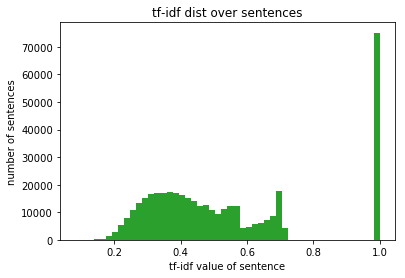

In [418]:
# plot the tf-idf distribution over sentences


# the histogram of the data
ax = plt.hist([x for x in stfidf if str(x) != 'nan'], 50)

plt.xlabel('tf-idf value of sentence')
plt.ylabel('number of sentences')
plt.title('tf-idf dist over sentences')
#labels = [item.get_text() for item in ax.get_yticklabels()]
#ax.set_xticklabels(labels)

plt.show()

Now, add a topic model. Our goal is to pare down the tf-idf space into a subspace defined by major topic axes, and use topics as a feature.

In [420]:
# create LSI model (try LDA later?)
lsi = models.LsiModel(corp_tfidf, id2word=dictionary, num_topics=200)
corp_lsi = lsi[corp_tfidf]
sentence_lsi = lsi[sentence_corp]
print(new_vec)          # in original dictionary
print(tfidf[new_vec])   # in tf-idf space
print(lsi[new_vec])     # in LSI/LSA topic space

[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]
[(2, 0.1217169239582691), (3, 0.30230312910390755), (4, 0.1828764398150676), (5, 0.017012819573171706), (6, 0.2557849334233673), (7, 0.8665596984748893), (8, 0.05368257118654773), (9, 0.019686602255689127), (10, 0.20110583368465484)]
[(0, 0.21326306826923844), (1, 0.050749118766525977), (2, 0.011672720479926013), (3, 0.0018034765397566366), (4, -0.017344280899082361), (5, -0.027501439065333137), (6, -0.011674899593848299), (7, -0.00071573178318109706), (8, 0.04267500172128022), (9, 0.048574825174033123), (10, 0.026575998528348774), (11, 0.044421532996683409), (12, 0.013393446951918003), (13, -0.030710753112995336), (14, -0.0042430543714664162), (15, 0.026780671636093815), (16, -0.048507526811905066), (17, -0.018350852246359284), (18, -0.0088498523285759148), (19, -0.0036967389008031003), (20, -0.00033181989194429155), (21, -0.048398855798007866), (22, 0.010960048997954872), (23, 0.0013603064206361322), (24, 0.006

In [421]:
# check out the most important topics in LSI
lsi.print_topics(20)
#[print(doc) for ndoc,doc in enumerate(corpus_lsi) if ndoc<20]

[(0,
  '0.098*"design" + 0.082*"life" + 0.079*"book" + 0.077*"user" + 0.075*"product" + 0.074*"compani" + 0.070*"learn" + 0.068*"success" + 0.066*"app" + 0.065*"busi"'),
 (1,
  '-0.322*"user" + -0.306*"design" + 0.237*"trump" + -0.219*"app" + -0.138*"ux" + -0.114*"code" + -0.104*"ui" + 0.101*"women" + 0.096*"presid" + -0.095*"product"'),
 (2,
  '0.407*"trump" + 0.165*"user" + 0.150*"presid" + 0.150*"clinton" + 0.143*"vote" + 0.134*"elect" + 0.132*"hillari" + 0.117*"design" + -0.111*"book" + 0.109*"women"'),
 (3,
  '-0.575*"que" + -0.395*"de" + -0.253*"não" + -0.230*"é" + -0.217*"e" + -0.149*"da" + -0.148*"um" + -0.143*"uma" + -0.140*"para" + -0.121*"se"'),
 (4,
  '0.275*"creatom" + 0.238*"jon" + 0.177*"startup" + 0.174*"compani" + 0.168*"agenc" + -0.138*"habit" + 0.127*"market" + 0.127*"gl" + 0.126*"goo" + 0.123*"westenberg"'),
 (5,
  '0.384*"trump" + -0.264*"women" + -0.174*"men" + -0.162*"black" + 0.113*"clinton" + -0.111*"woman" + -0.110*"girl" + -0.104*"white" + 0.100*"presid" + 0.

In [ ]:
# get each sentence's main topic. Do they cluster by article or not?
slsi = []
for sent_rep in sentence_lsi:
    #slsi = mean([wr[1] for wr in sent_rep])  # this needs to pick out a main topic.

In [ ]:
# HERE will be a plot that shows whether the sentence topics cluster by article.
# 2D space. Use 10 articles to start. Different color for article.
Make the scatter plot.....


# OR try 1D space and have D2 be the article ID.


In [534]:
# now, we set up for similarity queries 
sim_index = similarities.Similarity('.',lsi[corp],num_features = 200)

In [535]:
# find similarity between one highlight and each article
h_sim = sim_index[new_vec,new_vec]
#sorted_sims = sorted(enumerate(h_sim), key=lambda item: -item[1])
sorted_sims[0:10]
print(test_doc)
[ttext[ix] for ix,csim in sorted_sims[1:10]]
print(h_sim[0])
print(h_sim[1])


['today', 'air', 'forc', 'one', 'touch', 'havana', 'first', 'time', 'histori']
[ 0.07958278 -0.03962181  0.16909875 ..., -0.15677771 -0.00896206
 -0.21422096]
[ 0.07958278 -0.03962181  0.16909875 ..., -0.15677771 -0.00896206
 -0.21422096]


In [ ]:
# find cosine similarity of each sentence to its own article
dfS.head()

print(type(lsi))

# sent_own_sims = []
# for ax in range(len(ptext)):
#     if ax==0 or ax==1:#ax!=637:
#         s_sims = sim_sent_own_doc(ptext[ax],sim_index,ax,dictionary,lsi)
#         sent_own_sims.extend( s_sims )

[sent_own_sims.extend(sim_sent_own_doc(ptext[ax],sim_index,ax,dictionary,lsi)) 
for ax in range(len(ptext)) if ax!=637]        
        
#dfS[['postid','sentence']]
print(sent_own_sims)
#print(ptext[0]

<class 'gensim.models.lsimodel.LsiModel'>


In [580]:
def sim_sent_own_doc(docsents,index,docpos,dicty,mod):
    '''finds similarity of each sentence to its own doc'''
    a_lsi = [mod[dicty.doc2bow(s)] for s in docsents]
    sims = index[a_lsi]
    sims = [s[docpos] for s in sims]
    return sims

In [ ]:
# cosine similarity of sentence to title
print(len(sent_own_sims))

In [ ]:
# find sentiment of each sentence

In [ ]:
# find sentiment of each article

<b>Balancing Data</b>

In [ ]:
# Downsample negative sentences so ratio is ~2:1 neg:pos

In [ ]:
# Upsample positive sentence with data augmentation

# ideas: do they cluster in tf-idf space? try jitter...
#        shuffle/swap words from other highlights?
#        redistribute among highlights in the same article...